In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "./cifar-10-100n/")

import os
import torch
from PIL import Image as im
import pandas as pd
import numpy as np
from autogluon.vision import ImagePredictor, ImageDataset
import pickle
import datetime
from pathlib import Path
import cleanlab

from data.datasets import input_dataset
from cross_validation_autogluon import cross_val_predict_autogluon_image_dataset, train_predict_autogluon

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

In [2]:
# get labels
noise_file = torch.load('./data/CIFAR-10_human.pt')
clean_label = noise_file['clean_label']
worst_label = noise_file['worse_label']
aggre_label = noise_file['aggre_label']
random_label1 = noise_file['random_label1']
random_label2 = noise_file['random_label2']
random_label3 = noise_file['random_label3']

In [3]:
# get data
dataset = "cifar10"
noise_type = "aggre_label"
noise_path = "./data/CIFAR-10_human.pt"
is_human = True

train_dataset, test_dataset, num_classes, num_training_samples = \
    input_dataset(dataset, noise_type, noise_path, is_human)

Files already downloaded and verified
Loaded aggre_label from ./data/CIFAR-10_human.pt.
The overall noise rate is 0.09009999999999996
noisy labels loaded from ./data/CIFAR-10_human.pt
The noisy data ratio in each class is [0.10628 0.11018 0.10814 0.09242 0.08698 0.09926 0.09232 0.10006 0.10694
 0.09742]
over all noise rate is  0.0901


In [4]:
print(f"Accuracy of noisy labels vs true labels: {(aggre_label == clean_label).mean()}")

Accuracy of noisy labels vs true labels: 0.9099


In [5]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Manually inspect some images

In [6]:
label_errors_mask = aggre_label != clean_label

Datapoint index: 636
  Noisy Label: 2, bird
  True Label: 3, cat


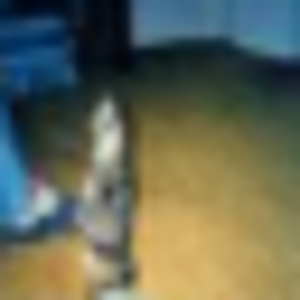

In [7]:
# check out some images
# idx = 0

# pick random image to inspect
idx = np.random.randint(0, train_dataset.train_data[label_errors_mask].shape[0])

X = train_dataset.train_data[label_errors_mask][idx]
noisy_label = np.array(train_dataset.train_noisy_labels)[label_errors_mask][idx]
true_label = np.array(train_dataset.train_labels)[label_errors_mask][idx]

print(f"Datapoint index: {idx}")
print(f"  Noisy Label: {noisy_label}, {classes[noisy_label]}")
print(f"  True Label: {true_label}, {classes[true_label]}")

newsize = (300, 300) # zoom in

im.fromarray(X).resize(newsize)

Datapoints to inspect further:

Datapoints (index) where the true label is wrong
  14023 (true label is airplane but looks like a bird)

## Save images to folder

AutoGluon image models require the data to be image files in a folder

We'll save the images as PNG files in a single folder and save their file paths in a list

In [8]:
%%time

# create folder
SAVE_PATH = "./cifar-10n-png/train/"
# os.makedirs(SAVE_PATH)

# save images to folder

image_file_paths = [] # list of image file paths

for i, data in enumerate(train_dataset.train_data):
    
    # convert data to image object
    image = im.fromarray(data) 

    # path to image PNG file
    png_file = f"{SAVE_PATH}image_id_{i}.png"
    
    # print the number of images saved
    print(f"Images saved: {i + 1}", end="\r")
    
    # append file to list of file paths
    image_file_paths.append(png_file)
    
    # save image as PNG
    image.save(png_file)

CPU times: user 17.7 s, sys: 3.85 s, total: 21.6 s
Wall time: 21.7 s


## Create DataFrame to use as input for AutoGluon Image predictor

In [9]:
# Note: AutoGluon requires the column names to be "image" and "label"
df_train = pd.DataFrame({
    "image": image_file_paths,
    "label": train_dataset.train_noisy_labels, # noisy labels
    "true_label": train_dataset.train_labels # true labels
})

In [10]:
df_train.reset_index().to_csv("cifar-10n-dataset-noise-type-aggre.csv", index=False)

In [11]:
assert (clean_label == df_train.true_label.values).all()

# Optional: copy the images to a faster drive (e.g. M.2 SSD) which will speedup training

In [12]:
# !cp -r ./cifar-10n-png/ /Data/cifar-10n-png/

In [13]:
# !ls /Data/cifar-10n-png

In [14]:
# # add prefix to file path if we moved it to another drive
# prefix = "/Data/"
# df_train["image"] = df_train.image.map(lambda f: str(Path(prefix + f)))
# df_train.head()

In [15]:
# !ls /Data

## Generate In-Sample Predicted Probabilities

In [16]:
%%time

# generate cross-validated predicted probabilities for various models so we can use them for ensemble scoring methods
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

epochs = 100
holdout_frac = 0.2
n_splits = 5

# run cross-validation for each model
for model in models:
    
    print("----")
    print(f"Running cross-validation for model: {model}")

    MODEL_PARAMS = {
        "model": model,
        "epochs": epochs,
        "holdout_frac": holdout_frac
    }

    # results of cross-validation will be saved to pickle files for each model/fold
    _ = \
        train_predict_autogluon(
            dataset=df_train, # train with NOISY LABELS
            classes=classes,
            out_folder=f"./noxval_cifar-10n-png_noise_type_aggre_cv_{model}/", # save results of cross-validation in pickle files for each fold
            n_splits=n_splits,
            model_params=MODEL_PARAMS,
            time_limit=60,
        )
    
    np.save(f"./noxval_cifar-10n-png_noise_type_aggre_cv_{model}/true_labels.npy", df_train.true_label)

modified configs(<old> != <new>): {
root.misc.seed       42 != 162
root.misc.num_workers 4 != 8
root.train.epochs    200 != 100
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != resnet18
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-aggregate/3c94fcac/.trial_0/config.yaml


----
Running cross-validation for model: resnet18
training...


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 275.299103 samples/sec	accuracy=0.130000	lr=0.000100
Epoch[0] Batch [99]	Speed: 589.239502 samples/sec	accuracy=0.138125	lr=0.000100
Epoch[0] Batch [149]	Speed: 588.856378 samples/sec	accuracy=0.163750	lr=0.000100
Epoch[0] Batch [199]	Speed: 609.611513 samples/sec	accuracy=0.182188	lr=0.000100
Epoch[0] Batch [249]	Speed: 618.838839 samples/sec	accuracy=0.199000	lr=0.000100
Epoch[0] Batch [299]	Speed: 602.117523 samples/sec	accuracy=0.208125	lr=0.000100
Epoch[0] Batch [349]	Speed: 586.690101 samples/sec	accuracy=0.221964	lr=0.000100
Epoch[0] Batch [399]	Speed: 585.827433 samples/sec	accuracy=0.237656	lr=0.000100
Epoch[0] Batch [449]	Speed: 621.769279 samples/sec	accuracy=0.250139	lr=0.000100
Epoch[0] Batch [499]	Speed: 587.543791 samples/sec	accuracy=0.261250	lr=0.0

predicting...
Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_aggre_cv_resnet18/
Folder ./noxval_cifar-10n-png_noise_type_aggre_cv_resnet18/ already exists!
saving pred_probs...
saving noisy_labels...
saving images...
saving indices...
saving predictor...


modified configs(<old> != <new>): {
root.misc.seed       42 != 363
root.misc.num_workers 4 != 8
root.train.epochs    200 != 100
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != resnet50d
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-aggregate/01ac65e3/.trial_0/config.yaml


----
Running cross-validation for model: resnet50d
training...


Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 203.332245 samples/sec	accuracy=0.107500	lr=0.000100
Epoch[0] Batch [99]	Speed: 242.164484 samples/sec	accuracy=0.116250	lr=0.000100
Epoch[0] Batch [149]	Speed: 241.990327 samples/sec	accuracy=0.126250	lr=0.000100
Epoch[0] Batch [199]	Speed: 242.283737 samples/sec	accuracy=0.139687	lr=0.000100
Epoch[0] Batch [249]	Speed: 241.878843 samples/sec	accuracy=0.139500	lr=0.000100
Epoch[0] Batch [299]	Speed: 240.318757 samples/sec	accuracy=0.144583	lr=0.000100
Epoch[0] Batch [349]	Speed: 241.866795 samples/sec	accuracy=0.148929	lr=0.000100
Epoch[0] Batch [399]	Speed: 241.532294 samples/sec	accuracy=0.156250	lr=0.000100
Epoch[0] Batch [449]	Speed: 242.233923 samples/sec	accuracy=0.160556	lr=0.000100
Epoch[0] Batch [499]	Speed: 242.776276 samples/sec	accuracy=0.163250	lr=0.

predicting...
Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_aggre_cv_resnet50d/
saving pred_probs...
saving noisy_labels...
saving images...
saving indices...
saving predictor...


modified configs(<old> != <new>): {
root.misc.seed       42 != 430
root.misc.num_workers 4 != 8
root.train.epochs    200 != 100
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != efficientnet_b1
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-aggregate/75351eb5/.trial_0/config.yaml


----
Running cross-validation for model: efficientnet_b1
training...


Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 182.898636 samples/sec	accuracy=0.108750	lr=0.000100
Epoch[0] Batch [99]	Speed: 215.202583 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [149]	Speed: 214.218241 samples/sec	accuracy=0.120417	lr=0.000100
Epoch[0] Batch [199]	Speed: 218.684361 samples/sec	accuracy=0.129375	lr=0.000100
Epoch[0] Batch [249]	Speed: 223.543369 samples/sec	accuracy=0.137750	lr=0.000100
Epoch[0] Batch [299]	Speed: 223.645178 samples/sec	accuracy=0.142917	lr=0.000100
Epoch[0] Batch [349]	Speed: 223.375387 samples/sec	accuracy=0.146607	lr=0.000100
Epoch[0] Batch [399]	Speed: 222.255729 samples/sec	accuracy=0.157031	lr=0.000100
Epoch[0] Batch [449]	Speed: 221.828491 samples/sec	accuracy=0.163333	lr=0.000100
Epoch[0] Batch [499]	Speed: 202.907513 samples/sec	accuracy=0.170000	

predicting...
Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_aggre_cv_efficientnet_b1/
saving pred_probs...
saving noisy_labels...
saving images...
saving indices...
saving predictor...


modified configs(<old> != <new>): {
root.misc.seed       42 != 245
root.misc.num_workers 4 != 8
root.train.epochs    200 != 100
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != twins_pcpvt_base
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-aggregate/12079cc8/.trial_0/config.yaml


----
Running cross-validation for model: twins_pcpvt_base
training...


Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 107.595160 samples/sec	accuracy=0.161250	lr=0.000100
Epoch[0] Batch [99]	Speed: 118.358144 samples/sec	accuracy=0.221250	lr=0.000100
Epoch[0] Batch [149]	Speed: 117.853401 samples/sec	accuracy=0.269583	lr=0.000100
Epoch[0] Batch [199]	Speed: 117.434596 samples/sec	accuracy=0.328750	lr=0.000100
Epoch[0] Batch [249]	Speed: 118.152354 samples/sec	accuracy=0.379500	lr=0.000100
Epoch[0] Batch [299]	Speed: 118.248812 samples/sec	accuracy=0.418333	lr=0.000100
Epoch[0] Batch [349]	Speed: 118.270823 samples/sec	accuracy=0.448036	lr=0.000100
Epoch[0] Batch [399]	Speed: 117.313217 samples/sec	accuracy=0.476719	lr=0.000100
Epoch[0] Batch [449]	Speed: 118.788646 samples/sec	accuracy=0.499306	lr=0.000100
`time_limit=59.999887466430664` reached, exit early...


predicting...
Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_aggre_cv_twins_pcpvt_base/
saving pred_probs...
saving noisy_labels...
saving images...
saving indices...
saving predictor...


modified configs(<old> != <new>): {
root.misc.seed       42 != 76
root.misc.num_workers 4 != 8
root.train.epochs    200 != 100
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 16
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-aggregate/db1a3914/.trial_0/config.yaml


----
Running cross-validation for model: swin_base_patch4_window7_224
training...


Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 74.968912 samples/sec	accuracy=0.152500	lr=0.000100
Epoch[0] Batch [99]	Speed: 79.695808 samples/sec	accuracy=0.197500	lr=0.000100
Epoch[0] Batch [149]	Speed: 79.733162 samples/sec	accuracy=0.252917	lr=0.000100
Epoch[0] Batch [199]	Speed: 79.655523 samples/sec	accuracy=0.303125	lr=0.000100
Epoch[0] Batch [249]	Speed: 79.644523 samples/sec	accuracy=0.359750	lr=0.000100
Epoch[0] Batch [299]	Speed: 79.552905 samples/sec	accuracy=0.410417	lr=0.000100
`time_limit=59.99989318847656` reached, exit early...


predicting...
Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_aggre_cv_swin_base_patch4_window7_224/
saving pred_probs...
saving noisy_labels...
saving images...
saving indices...
saving predictor...
CPU times: user 12min 34s, sys: 2min 5s, total: 14min 39s
Wall time: 14min 49s
